<a href="https://colab.research.google.com/github/crialejo24/mi_repositorio/blob/master/SwinIR_SAR_FINAL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **APLICACIÓN DE TRANSFORMER SwinIR**

Creamos una serie de funciones para hallar las metricas de nuestros transformer

In [ ]:
from google.colab import files
import os
import shutil
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import matplotlib.pyplot as plt
import glob

# Configuración inicial
os.makedirs('BSRGAN/testsets/RealSRSet', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('ground_truth', exist_ok=True)

# Función para limpiar nombres de archivos
def clean_filename(filename):
    """Elimina (1), espacios y otros modificadores del nombre del archivo"""
    return filename.replace(" ", "").split('(')[0].split(')')[0].strip()

# Función para calcular métricas
def calculate_metrics(gt_img, processed_img, x=None, y=None, patch_size=20):
    """Calcula PSNR, SSIM y EML entre dos imágenes, con opción de región específica para EML"""

    if gt_img is None or processed_img is None:
        return None

    # Asegurar que las imágenes tengan el mismo tamaño
    if gt_img.shape != processed_img.shape:
        processed_img = cv2.resize(processed_img, (gt_img.shape[1], gt_img.shape[0]))

    # Convertir a escala de grises para SSIM y EML
    gt_gray = cv2.cvtColor(gt_img, cv2.COLOR_RGB2GRAY)
    proc_gray = cv2.cvtColor(processed_img, cv2.COLOR_RGB2GRAY)

    # Calcular métricas globales
    metrics = {
        'PSNR': psnr(gt_img, processed_img),
        'SSIM': ssim(gt_gray, proc_gray),
        'EML': calculate_eml(gt_gray, x, y, patch_size) if (x is not None and y is not None) else 0
    }
    return metrics

def calculate_eml(image, x, y, patch_size=20):
    """Calcula EML en una región específica"""
    if image is None:
        return 0

    # Extraer parche de la región homogénea
    h, w = image.shape
    x_start = max(0, min(x, w - patch_size))
    y_start = max(0, min(y, h - patch_size))
    patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]

    mean = np.mean(patch)
    var = np.var(patch)

    return (mean**2) / var if var != 0 else 0

def draw_red_box(img, x, y, patch_size=20, thickness=2):
    """Dibuja un cuadro rojo en la imagen sin modificarla (copia)"""
    img_copy = img.copy()
    h, w = img.shape[:2]
    x_start = max(0, min(x, w - patch_size))
    y_start = max(0, min(y, h - patch_size))

    cv2.rectangle(img_copy,
                 (x_start, y_start),
                 (x_start+patch_size, y_start+patch_size),
                 (255, 0, 0), thickness)
    return img_copy

def display_results(input_img, results, gt_img, eml_x=380, eml_y=100, patch_size=20):
    """Muestra resultados con métricas y región de EML resaltada"""

    models = ['Input', 'BSRGAN', 'RealESRGAN', 'SwinIR', 'SwinIR-Large']
    available = ['Input'] + [m for m in models[1:] if results.get(m) is not None]

    cols = 1 + len(available)  # GT + modelos disponibles
    plt.figure(figsize=(cols*6, 6))

    # Ground Truth (referencia)
    plt.subplot(1, cols, 1)
    gt_title = 'Ground Truth'
    if eml_x is not None and eml_y is not None:
        gt_img_display = draw_red_box(gt_img, eml_x, eml_y, patch_size)
        gt_title += f"\nEML region: ({eml_x},{eml_y})"
    else:
        gt_img_display = gt_img

    plt.title(gt_title, fontsize=10)
    plt.imshow(gt_img_display)
    plt.axis('off')

    # Resultados de cada modelo (incluyendo input noisy)
    for i, model in enumerate(available, 2):
        plt.subplot(1, cols, i)

        if model == 'Input':
            img = input_img
            title = "Input (Noisy)"
        else:
            img = results[model]
            title = model

        # Dibujar cuadro rojo si hay coordenadas
        if eml_x is not None and eml_y is not None:
            img_display = draw_red_box(img, eml_x, eml_y, patch_size)
        else:
            img_display = img

        # Calcular métricas respecto a GT
        metrics = calculate_metrics(gt_img, img, eml_x, eml_y, patch_size)

        # Construir título con métricas
        if metrics:
            title += f"\nPSNR: {metrics['PSNR']:.2f} dB\nSSIM: {metrics['SSIM']:.3f}"
            if eml_x is not None and eml_y is not None:
                title += f"\nEML: {metrics['EML']:.1f} (20x20)"

        plt.title(title, fontsize=8)
        plt.imshow(img_display)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Paso 1: Subir imágenes noisy

In [ ]:
print("1️⃣ Sube las imágenes noisy (puedes seleccionar varias)")
uploaded_noisy = files.upload()
for filename in uploaded_noisy.keys():
    clean_name = clean_filename(filename)
    if filename.lower().endswith(('.tiff', '.tif')):
        img = Image.open(filename)
        new_name = os.path.splitext(clean_name)[0] + '.png'
        img.save(new_name)
        dst = os.path.join('BSRGAN/testsets/RealSRSet', new_name)
        os.remove(filename)
        shutil.move(new_name, dst)
    else:
        dst = os.path.join('BSRGAN/testsets/RealSRSet', clean_name)
        shutil.move(filename, dst)
    print(f"✅ Noisy: {clean_name} subida correctamente")

1️⃣ Sube las imágenes noisy (puedes seleccionar varias)


Saving 0_1536.tiff to 0_1536.tiff
Saving 0_1024.tiff to 0_1024.tiff
✅ Noisy: 0_1536.tiff subida correctamente
✅ Noisy: 0_1024.tiff subida correctamente


# Paso 2: Subir imágenes ground truth

In [ ]:
print("\n2️⃣ Sube las imágenes ground truth (deben tener el mismo nombre que las noisy)")
uploaded_gt = files.upload()
for filename in uploaded_gt.keys():
    clean_name = clean_filename(filename)
    if clean_name != filename:
        os.rename(filename, clean_name)

    if filename.lower().endswith(('.tiff', '.tif')):
        img = Image.open(clean_name)
        new_name = os.path.splitext(clean_name)[0] + '.png'
        img.save(new_name)
        dst = os.path.join('ground_truth', new_name)
        os.remove(clean_name)
        shutil.move(new_name, dst)
    else:
        dst = os.path.join('ground_truth', clean_name)
        shutil.move(clean_name, dst)
    print(f"✅ GT: {clean_name} subida correctamente")


2️⃣ Sube las imágenes ground truth (deben tener el mismo nombre que las noisy)


Saving 0_1536 (1).tiff to 0_1536 (1).tiff
Saving 0_1024 (1).tiff to 0_1024 (1).tiff
✅ GT: 0_1536 subida correctamente
✅ GT: 0_1024 subida correctamente


# Paso 3: Procesar con los modelos

In [ ]:
print("\n⚙️ Ejecutando modelos de super-resolución...")
test_patch_wise = False  # Cambiar a True si tienes problemas de memoria

# 1. BSRGAN
if not test_patch_wise:
    %cd BSRGAN
    !python main_test_bsrgan.py
    %cd ..
    # Check if the destination directory already exists and remove it if necessary
    if os.path.exists('results/BSRGAN/RealSRSet_results_x4'):
        shutil.rmtree('results/BSRGAN/RealSRSet_results_x4') # Remove the existing directory
    shutil.move('BSRGAN/testsets/RealSRSet_results_x4', 'results/BSRGAN') # Now move the new directory

# 2. RealESRGAN
!python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN {'' if test_patch_wise else '--tile 800'}

# 3. SwinIR
!python SwinIR/main_test_swinir.py --task real_sr \
    --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth \
    --folder_lq BSRGAN/testsets/RealSRSet --scale 4 {'' if test_patch_wise else '--tile 800'}
# Check if the destination directory already exists and remove it if necessary
if os.path.exists('results/SwinIR/swinir_real_sr_x4'):
    shutil.rmtree('results/SwinIR/swinir_real_sr_x4') # Remove the existing directory if it exists before moving the new one
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR') # Now move the new directory

# 4. SwinIR-Large
!python SwinIR/main_test_swinir.py --task real_sr \
    --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth \
    --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model {'' if test_patch_wise else '--tile 640'}
# Check if the destination directory already exists and remove it if necessary
if os.path.exists('results/SwinIR_large/swinir_real_sr_x4_large'):
    shutil.rmtree('results/SwinIR_large/swinir_real_sr_x4_large') # Remove existing directory
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large') # Move the new directory

# Renombrar outputs de SwinIR-Large
for path in glob.glob('results/SwinIR_large/*SwinIR.png'):
    os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png'))


⚙️ Ejecutando modelos de super-resolución...
/content/Real-ESRGAN/BSRGAN
LogHandlers setup!
25-05-14 06:02:40.774 :       Model Name : BSRGAN
25-05-14 06:02:40.790 :           GPU ID : 0
[3, 3, 64, 23, 32, 4]
25-05-14 06:02:41.384 :       Input Path : testsets/RealSRSet
25-05-14 06:02:41.385 :      Output Path : testsets/RealSRSet_results_x4
25-05-14 06:02:41.385 : ---1 --> BSRGAN --> x4--> 0_1024.png
25-05-14 06:02:44.236 : ---2 --> BSRGAN --> x4--> 0_1536.png
/content/Real-ESRGAN
Traceback (most recent call last):
  File "/content/Real-ESRGAN/inference_realesrgan.py", line 5, in <module>
    from basicsr.archs.rrdbnet_arch import RRDBNet
  File "/usr/local/lib/python3.11/dist-packages/basicsr/__init__.py", line 4, in <module>
    from .data import *
  File "/usr/local/lib/python3.11/dist-packages/basicsr/data/__init__.py", line 22, in <module>
    _dataset_modules = [importlib.import_module(f'basicsr.data.{file_name}') for file_name in dataset_filenames]
                       ^^^^^

# Paso 4: Visualizar resultados con métricas


📊 Resultados finales con métricas:

🔍 0_1024.png


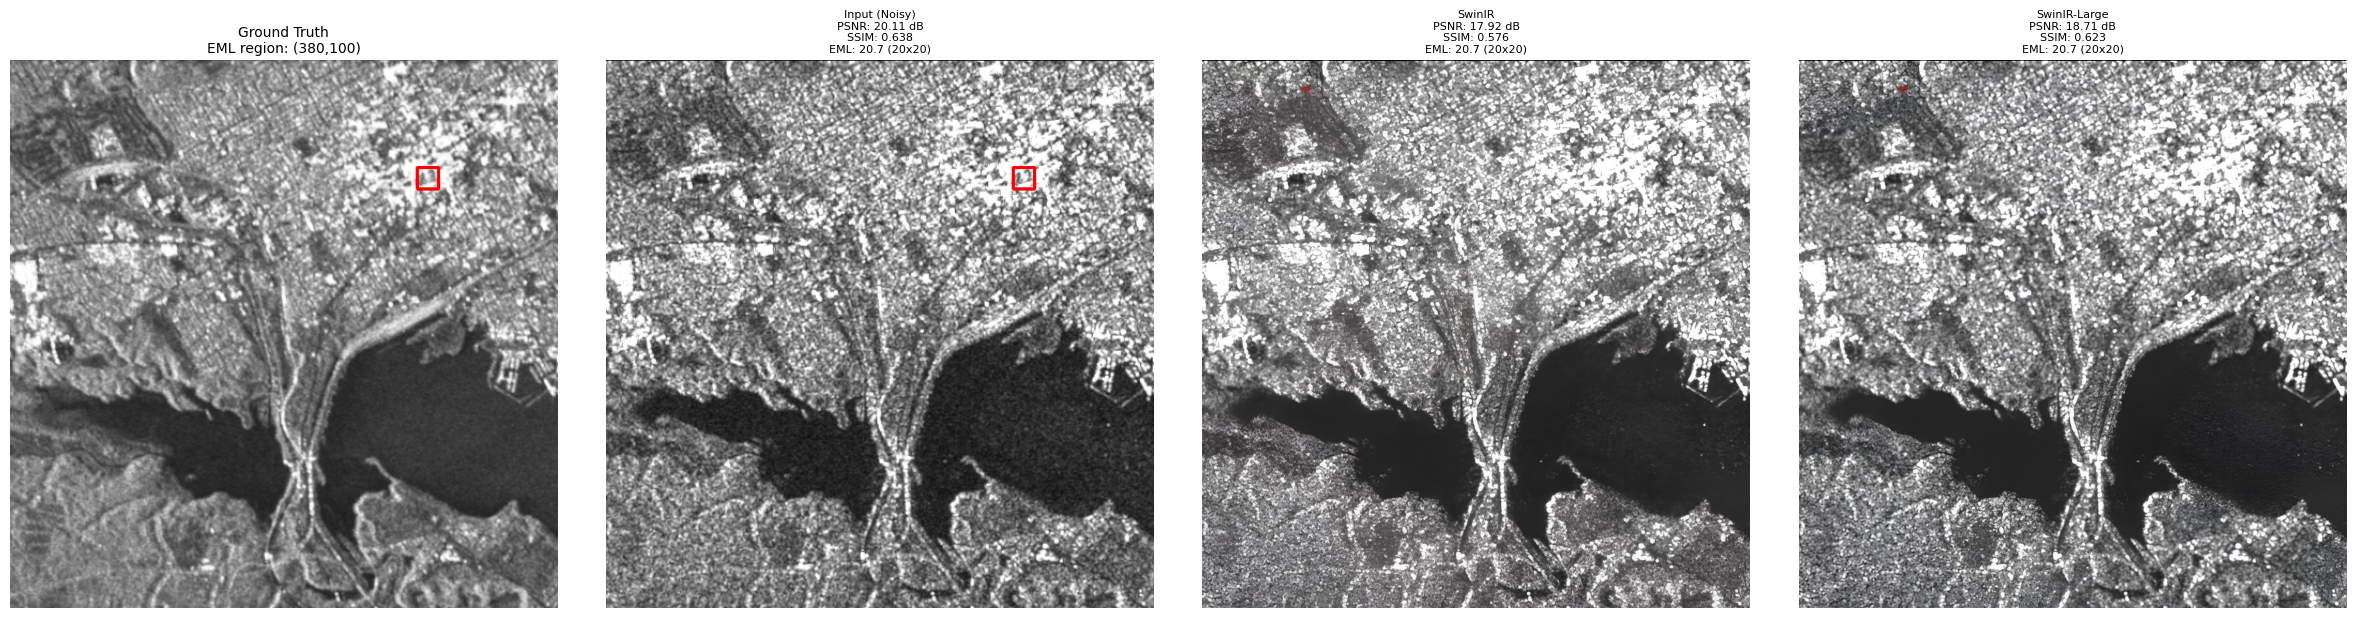


🔍 0_1536.png


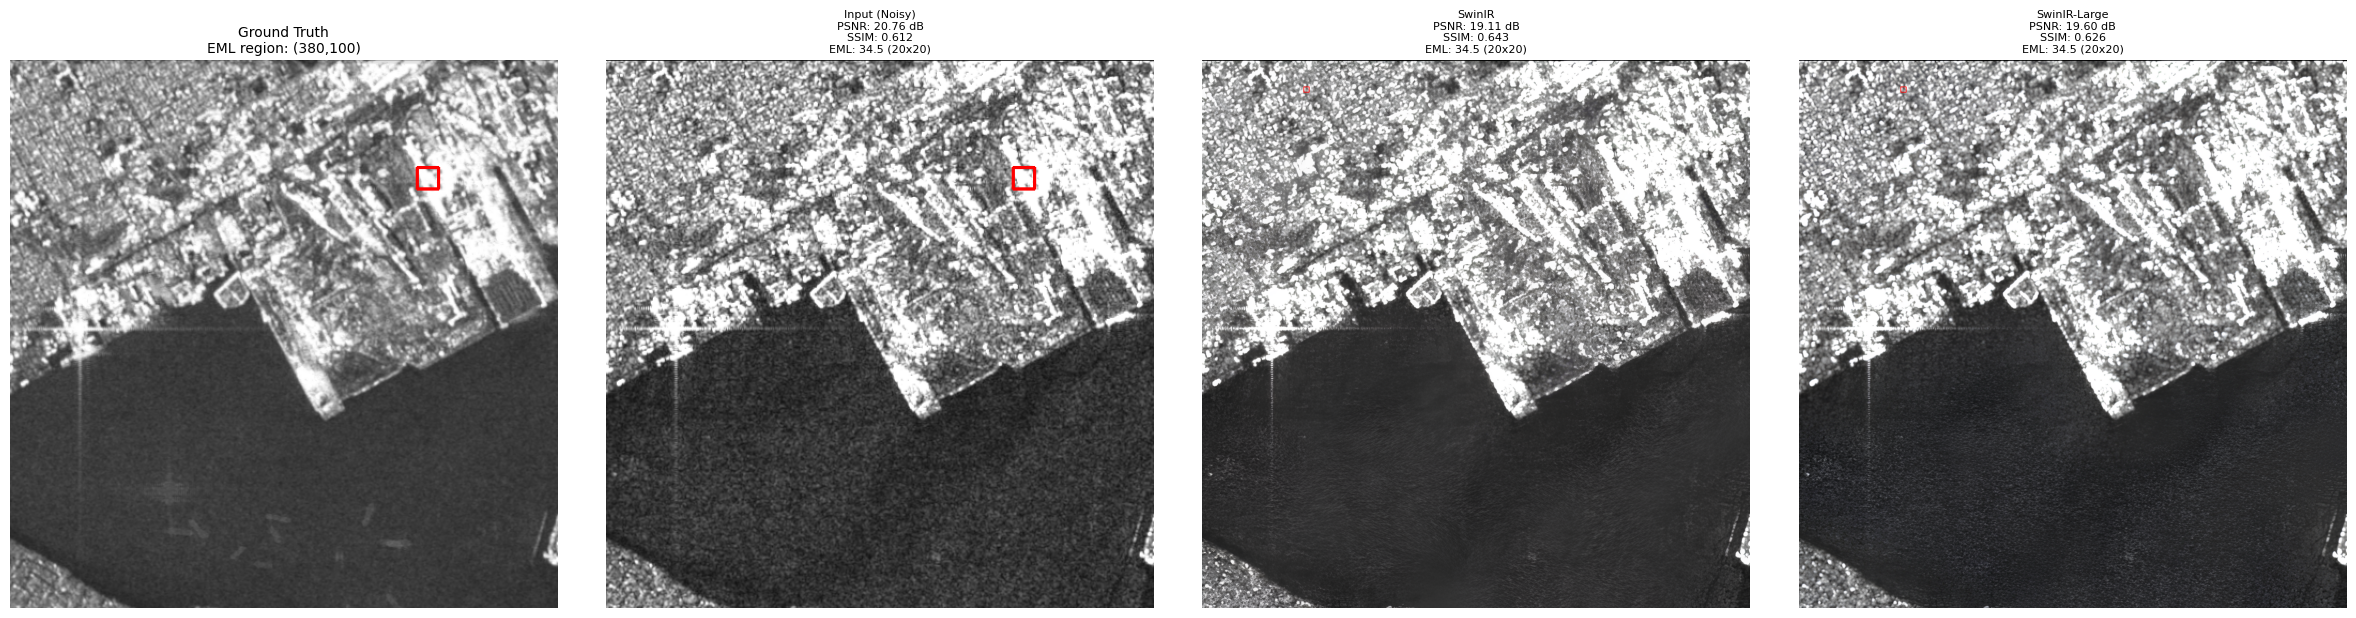


✅ Proceso completado!


In [ ]:
print("\n📊 Resultados finales con métricas:")
input_images = sorted(glob.glob('BSRGAN/testsets/RealSRSet/*'))
for img_path in input_images:
    try:
        img_name = os.path.basename(img_path)
        base_name = os.path.splitext(img_name)[0]

        # Cargar imágenes
        input_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        gt_path = os.path.join('ground_truth', img_name)
        gt_img = cv2.cvtColor(cv2.imread(gt_path), cv2.COLOR_BGR2RGB) if os.path.exists(gt_path) else None

        if gt_img is None:
            print(f"⚠️ No se encontró ground truth para {img_name}")
            continue

        # Cargar resultados de cada modelo
        results = {
            'BSRGAN': cv2.cvtColor(cv2.imread(f'results/BSRGAN/{base_name}.png'), cv2.COLOR_BGR2RGB) if os.path.exists(f'results/BSRGAN/{base_name}.png') else None,
            'RealESRGAN': cv2.cvtColor(cv2.imread(f'results/realESRGAN/{base_name}_realESRGAN.png'), cv2.COLOR_BGR2RGB) if os.path.exists(f'results/realESRGAN/{base_name}_realESRGAN.png') else None,
            'SwinIR': cv2.cvtColor(cv2.imread(f'results/SwinIR/{base_name}_SwinIR.png'), cv2.COLOR_BGR2RGB) if os.path.exists(f'results/SwinIR/{base_name}_SwinIR.png') else None,
            'SwinIR-Large': cv2.cvtColor(cv2.imread(f'results/SwinIR_large/{base_name}_SwinIR_large.png'), cv2.COLOR_BGR2RGB) if os.path.exists(f'results/SwinIR_large/{base_name}_SwinIR_large.png') else None
        }

        # Mostrar resultados
        print(f"\n🔍 {img_name}")
        display_results(input_img, results, gt_img)

    except Exception as e:
        print(f"⚠️ Error procesando {img_name}: {str(e)}")

print("\n✅ Proceso completado!")

# **Análisis Métrico**
1. PSNR:
El valor más alto es el del input original (20.11 dB).

Los métodos SwinIR y SwinIR-Large tienen un PSNR más bajo, lo que indica pérdida de fidelidad respecto al ground truth. Esto sugiere que los modelos pueden estar difuminando o alterando excesivamente los detalles originales.

2. SSIM:
También es mayor en la imagen de entrada (0.638), lo que sorprende, ya que se esperaría que los transformadores mejoraran la similitud estructural.

SwinIR: 0.576 (peor)

SwinIR-Large: 0.623 (mejor que SwinIR, pero menor que el input) Esto podría indicar que, los transformadores no están optimizados para mantener la estructura SAR fina, o que están sobreajustando a la remoción de ruido, sacrificando estructuras locales.

3. ENL:
Todos los modelos tienen el mismo ENL: 20.7. Esto sugiere que la región específica seleccionada (380,100) tiene una respuesta muy homogénea, y los modelos no alteraron significativamente esa homogeneidad.

Sin embargo, puede indicar que ENL no es sensible al tipo de modificación que los modelos introducen. Tal vez sería útil aplicar EML en más regiones para una evaluación más robusta.